In [1]:
using Revise

In [2]:
using PyCall, PyPlot
using ClimateMARGO

In [3]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Plotting
using ClimateMARGO.Optimization
using ClimateMARGO.PolicyResponse

In [4]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");
rcParams["lines.linestyle"] = "-";


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded

Control re-adjustments due to passage of time
Solve_Succeeded
NPV: 188.3591367815317 - 193.73654043481315 = -5.377403653281448
T = 2.000000000666292 to 2.000000001325509
Solve_Succeeded
NPV: 177.67034692407555 - 188.04164643268356 = -10.371299508608018
T = 2.000000001325509 to 2.0000000177532424
Infeasible_Problem_Detected

Response to variability in baseline emissions
Infeasible_Problem_Detected
Infeasible_Problem_Detected
NPV: 1764.337740524297 - 1722.631872321566 = 41.705868202730926
T = 3.002423762707141 to 3.002423762707141
Infeasible_Problem_Detected
Infeasible_Problem_Detected
NPV:

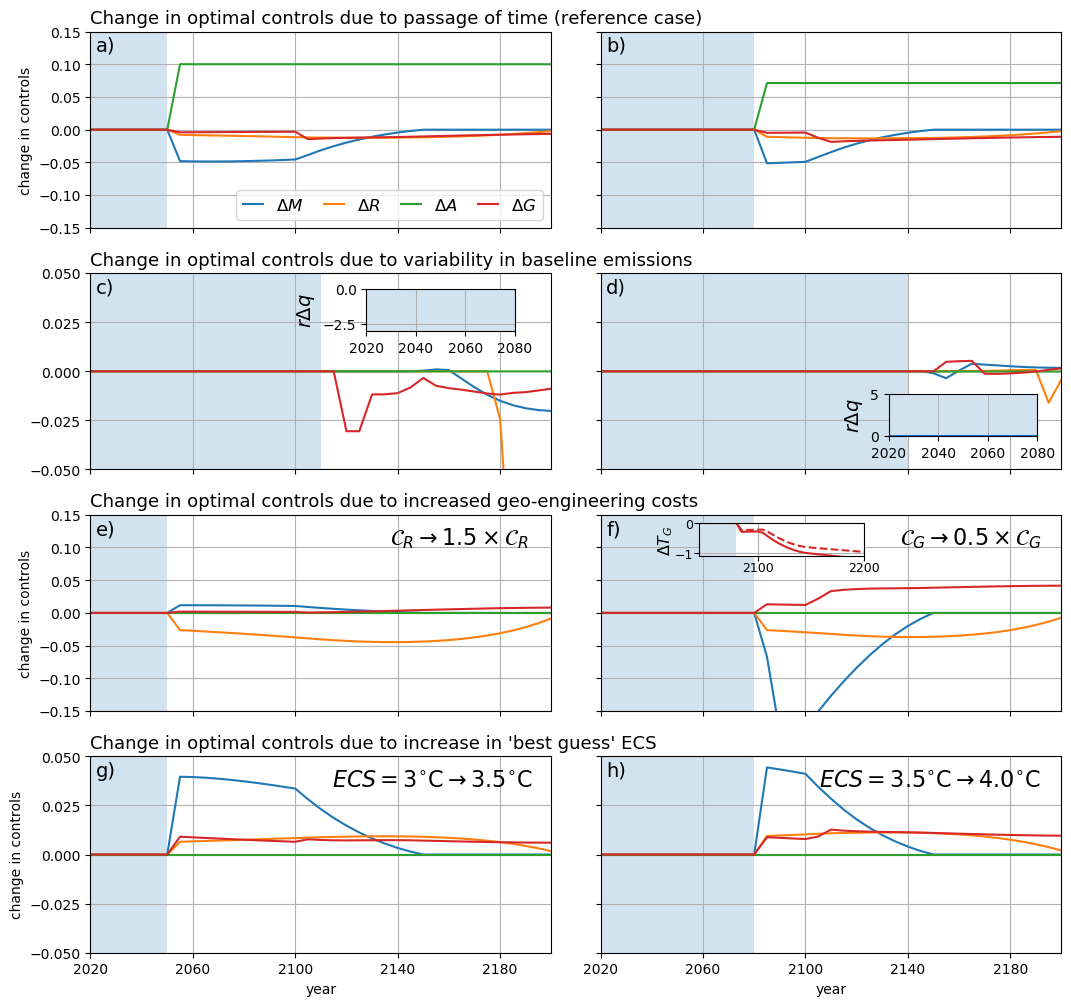

Infeasible_Problem_Detected
Solve_Succeeded
NPV: 246.3792114959078 - 168.74872073944135 = 77.63049075646646
T = 2.228289097163358 to 2.193829335878592


In [5]:
control_dict = Dict()
model_dict = Dict()

model = ClimateModel(ClimateMARGO.IO.included_configurations["default"]);
optimize_controls!(model);

Δt = 30.
Δq_samples = [-2., 4.]/model.physics.r

ensemble = Dict()
ensemble[string(Int64(model.domain.present_year))] = deepcopy(model);

fig = figure(figsize=(11,10))
ylims = [-0.15, 0.15]

print("\nControl re-adjustments due to passage of time\n")
previous_year = deepcopy(model.domain.present_year)
for (n, Δq) in enumerate(Δq_samples)
    control_name = deepcopy(string(Int64(model.domain.present_year + Δt), "_control"))

    # optimize before adding emissions
    control = deepcopy(model)
    control_dict[n] = deepcopy(model)
    step_forward!(control, Δt)

    step_forward!(model, Δt)
    NPV_old = deepcopy(net_present_cost(model, M=true, R=true, G=true, A=true))
    maxT_old = deepcopy(maximum(T(model, M=true, R=true, G=true, A=true)))

    m = optimize_controls!(model);
    model_dict[n] = deepcopy(model)

    NPV_revised = net_present_cost(model, M=true, R=true, G=true, A=true)
    maxT_revised = maximum(T(model, M=true, R=true, G=true, A=true))
    NPV_diff = NPV_revised - NPV_old
    print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
    print("T = $maxT_old to $maxT_revised\n")

    # Plotting
    fig.add_subplot(4, length(Δq_samples), n)
    fill_between([2020, model.domain.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
    plot(t(model), model.controls.mitigate .- control.controls.mitigate)
    plot(t(model), model.controls.remove .- control.controls.remove)
    plot(t(model), model.controls.adapt .- control.controls.adapt)
    plot(t(model), model.controls.geoeng .- control.controls.geoeng)
    xlim([2020, 2200])
    ylim(ylims)
    xlabel("")
    ylabel("")
    locs, labels = xticks()
    xticks(locs, labels=[])
    locs, labels = yticks(-0.15:0.05:0.15)
    if n==2
        locs, labels = yticks()
        yticks(locs, labels=[])
    end
    grid(true)
    
    if n==1
        ylabel("change in controls");
        plot([], [], "C0-", label=L"$\Delta M$")
        plot([], [], "C1-", label=L"$\Delta R$")
        plot([], [], "C2-", label=L"$\Delta A$")
        plot([], [], "C3-", label=L"$\Delta G$")
        legend(loc="lower right", handlelength=1.2, ncol=4, fontsize=12, columnspacing=1.2)
    end
end

model = ClimateModel(ClimateMARGO.IO.included_configurations["default"]);
optimize_controls!(model)
print("\nResponse to variability in baseline emissions\n")
previous_year = deepcopy(model.domain.present_year)
for (n, Δq) in enumerate(Δq_samples)
    control_name = deepcopy(string(Int64(model.domain.present_year + Δt), "_control"))

    # optimize before adding emissions
    control = deepcopy(model)
    control_dict[n] = deepcopy(model)
    step_forward!(control, Δt)
    mcontrol = optimize_controls!(control);
    PolicyResponse.add_emissions_bump!(control, Δt, Δq, present_year = control.domain.present_year - Δt)
    ensemble[control_name] = deepcopy(control)
    
    # optimize after adding emissions
    PolicyResponse.add_emissions_bump!(model, Δt, Δq)
    step_forward!(model, Δt)
    
    NPV_old = deepcopy(net_present_cost(model, M=true, R=true, G=true, A=true))
    maxT_old = deepcopy(maximum(T(model, M=true, R=true, G=true, A=true)))
    
    m = optimize_controls!(model);
    model_dict[n] = deepcopy(model)

    NPV_revised = net_present_cost(model, M=true, R=true, G=true, A=true)
    maxT_revised = maximum(T(model, M=true, R=true, G=true, A=true))
    NPV_diff = NPV_revised - NPV_old
    print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
    print("T = $maxT_old to $maxT_revised\n")

    # Plotting
    fig.add_subplot(4, length(Δq_samples), length(Δq_samples)+n)
    fill_between([2020, model.domain.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
    plot(t(model), model.controls.mitigate .- control.controls.mitigate)
    plot(t(model), model.controls.remove .- control.controls.remove)
    plot(t(model), model.controls.adapt .- control.controls.adapt)
    plot(t(model), model.controls.geoeng .- control.controls.geoeng)
    xlim([2020, 2200])
    ylim(ylims ./ 3.)
    xlabel("")
    ylabel("")
    locs, labels = xticks()
    xticks(locs, labels=[])
    locs, labels = yticks(-0.05:0.025:0.05)
    if n==1
    else
        locs, labels = yticks()
        yticks(locs, labels=[])
    end
    grid(true)
    
    ensemble[model.name] = deepcopy(model);
end

########
print("\nResponse to higher geoengineering costs\n")

model = deepcopy(ensemble["2020"])
step_forward!(model, Δt)
control = deepcopy(model)
cost_control = deepcopy(control)

model.economics.remove_cost *= 1.5
NPV_old = deepcopy(net_present_cost(model, M=true, R=true, G=true, A=true))
maxT_old = deepcopy(maximum(T(model, M=true, R=true, G=true, A=true)))

optimize_controls!(model);
optimize_controls!(control);
control.economics.remove_cost *= 1.5

NPV_revised = net_present_cost(model, M=true, R=true, G=true, A=true)
maxT_revised = maximum(T(model, M=true, R=true, G=true, A=true))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

cost_overrun = (
    sum(model.domain.dt * (f(model.controls.remove) * model.economics.remove_cost)[t(model) .< model.domain.present_year]) -
    sum(model.domain.dt * (f(cost_control.controls.remove) * cost_control.economics.remove_cost)[t(model) .< model.domain.present_year])
)
print("Cost overuns: $cost_overrun\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*2+1)
fill_between([2020, model.domain.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(t(model), model.controls.mitigate .- control.controls.mitigate)
plot(t(model), model.controls.remove .- control.controls.remove)
plot(t(model), model.controls.adapt .- control.controls.adapt)
plot(t(model), model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("")
ylabel("change in controls")
grid(true)
locs, labels = xticks()
xticks(locs, labels=[])
locs, labels = yticks(-0.15:0.05:0.15)
ylim(ylims)
annotate(s=L"$\mathcal{C}_{R} \rightarrow 1.5 \times \mathcal{C}_{R}$", xy=(0.65, 0.85), xycoords="axes fraction", fontsize=16)

step_forward!(model, Δt)
control = deepcopy(model)
cost_control = deepcopy(control)

model.economics.geoeng_cost *= 0.5

NPV_old = deepcopy(net_present_cost(model, M=true, R=true, G=true, A=true))
maxT_old = deepcopy(maximum(T(model, M=true, R=true, G=true, A=true)))

optimize_controls!(model);
optimize_controls!(control);
control.economics.geoeng_cost *= 0.5

model_dict["G_control"] = deepcopy(control)
model_dict["G_model"] = deepcopy(model)

NPV_revised = net_present_cost(model, M=true, R=true, G=true, A=true)
maxT_revised = maximum(T(model, M=true, R=true, G=true, A=true))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

cost_overrun = (
    sum(model.domain.dt * (f(model.controls.geoeng) .* E(model) * model.economics.geoeng_cost)[t(model) .< model.domain.present_year]) -
    sum(model.domain.dt * (f(cost_control.controls.geoeng) .* E(model) * cost_control.economics.geoeng_cost)[t(model) .< model.domain.present_year])
)
print("Cost overuns: $cost_overrun\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*2+2)
fill_between([2020, model.domain.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(t(model), model.controls.mitigate .- control.controls.mitigate)
plot(t(model), model.controls.remove .- control.controls.remove)
plot(t(model), model.controls.adapt .- control.controls.adapt)
plot(t(model), model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("")
ylabel("")
grid(true)
locs, labels = xticks()
xticks(locs, labels=[])
locs, labels = yticks(-0.15:0.05:0.15, [])
ylim(ylims)
annotate(s=L"$\mathcal{C}_{G} \rightarrow 0.5 \times \mathcal{C}_{G}$", xy=(0.65, 0.85), xycoords="axes fraction", fontsize=16)

########################################################
########################################################
print("\nResponse to higher climate sensitivity\n")

model = deepcopy(ensemble["2020"])
step_forward!(model, Δt)
control = deepcopy(model)

model.physics.B = ensemble["2020"].physics.B * F2x(model)/(F2x(model) + 0.5)

NPV_old = deepcopy(net_present_cost(model, M=true, R=true, G=true, A=true))
maxT_old = deepcopy(maximum(T(model, M=true, R=true, G=true, A=true)))

optimize_controls!(model);
optimize_controls!(control);
control.physics.B = ensemble["2020"].physics.B * F2x(model)/(F2x(model) + 0.5)

NPV_revised = net_present_cost(model, M=true, R=true, G=true, A=true)
maxT_revised = maximum(T(model, M=true, R=true, G=true, A=true))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*3+1)
fill_between([2020, model.domain.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(t(model), model.controls.mitigate .- control.controls.mitigate)
plot(t(model), model.controls.remove .- control.controls.remove)
plot(t(model), model.controls.adapt .- control.controls.adapt)
plot(t(model), model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("year")
ylabel("change in controls")
locs, labels = yticks(-0.05:0.025:0.05)
grid(true)
ylim(ylims ./3.)
annotate(s=L"$ECS = 3^{\circ}$C$\rightarrow 3.5^{\circ}$C", xy=(0.525, 0.85), xycoords="axes fraction", fontsize=16)

step_forward!(model, Δt)
control = deepcopy(model)

model.physics.B = ensemble["2020"].physics.B * F2x(ensemble["2020"])/(F2x(ensemble["2020"]) + 1.05)

NPV_old = deepcopy(net_present_cost(model, M=true, R=true, G=true, A=true))
maxT_old = deepcopy(maximum(T(model, M=true, R=true, G=true, A=true)))

old_model = deepcopy(model)

m = optimize_controls!(model, temp_goal = 2.0);
m = optimize_controls!(control, temp_goal = 2.0);
control.physics.B = ensemble["2020"].physics.B * F2x(ensemble["2020"])/(F2x(ensemble["2020"]) + 1.05)

NPV_revised = net_present_cost(model, M=true, R=true, G=true, A=true)
maxT_revised = maximum(T(model, M=true, R=true, G=true, A=true))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*3+2)
fill_between([2020, model.domain.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(t(model), model.controls.mitigate .- control.controls.mitigate)
plot(t(model), model.controls.remove .- control.controls.remove)
plot(t(model), model.controls.adapt .- control.controls.adapt)
plot(t(model), model.controls.geoeng .- control.controls.geoeng)

xlim([2020, 2200])
xlabel("year")
ylabel("")
locs, labels = yticks(-0.05:0.025:0.05, labels=[])
grid(true)
ylim(ylims ./3.)
annotate(s=L"$ECS = 3.5^{\circ}$C$\rightarrow 4.0^{\circ}$C", xy=(0.475, 0.85), xycoords="axes fraction", fontsize=16)

iax = fig.add_axes([0.3375, 0.68, 0.135, 0.0425])
sca(iax)
fill_between([2020, model_dict[1].domain.present_year], [0, 0], [-3, -3], facecolor="C0", alpha=0.2)
plot(t(model), effective_emissions(model_dict[1]) - effective_emissions(control_dict[1]), "C0-")
ylabel(L"$r Δq$", fontsize=14)
grid(true)
xlabel("")
xlim([2020,2080])
ylim([-3, 0])
title("")

iax = fig.add_axes([0.8125, 0.575, 0.135, 0.0425])
sca(iax)
fill_between([2020, model_dict[2].domain.present_year], [0, 0], [5., 5.], facecolor="C0", alpha=0.2)
plot(t(model), effective_emissions(model_dict[2]) - effective_emissions(control_dict[2]), "C0-")
ylabel(L"$r Δq$", fontsize=14)
grid(true)
xlabel("")
xlim([2020,2080])
ylim([0, 5])
title("")

iax = fig.add_axes([0.64, 0.455, 0.15, 0.033])
sca(iax)
fill_between([2020, 2080.], [0, 0], [-1.5, -1.5], facecolor="C0", alpha=0.2)
plot(t(model), T(model_dict["G_control"], M=true, R=true, G=true) .- T(model_dict["G_control"], M=true, R=true), "C3--")
plot(t(model), T(model_dict["G_model"], M=true, R=true, G=true) .- T(model_dict["G_model"], M=true, R=true), "C3-")
ylabel(L"$\Delta T_{G}$", fontsize=11.5, labelpad=0.25)
grid(true)
xlabel("")
tick_params(pad=0.5)
xticks(fontsize=9.)
yticks(fontsize=9.)
xlim([2045, 2200])
ylim([-1.1, 0.])
title("")

labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]
for n = 1:8
    fig.add_subplot(4, 2, n)
    annotate(s=labels[n], xy=(0.0125, 0.9), xycoords="axes fraction", fontsize=14)
    xticks(2020:40:2200)
end

tight_layout(h_pad=2.25)

fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*0+1)
tit = title("Change in optimal controls due to passage of time (reference case)", loc="left", fontsize=13)

fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*1+1)
tit = title("Change in optimal controls due to variability in baseline emissions", loc="left", fontsize=13)

fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*2+1)
tit = title("Change in optimal controls due to increased geo-engineering costs", loc="left", fontsize=13)

fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*3+1)
tit = title("Change in optimal controls due to increase in 'best guess' ECS", loc="left", fontsize=13)

savefig("../../figures/policy_updates.pdf", dpi=150, bbox_inches="tight")

model = deepcopy(ensemble["2020"])
step_forward!(model, 3*Δt)
control = deepcopy(model)

model.physics.B = ensemble["2020"].physics.B * F2x(ensemble["2020"])/(F2x(ensemble["2020"]) + 1.05)

NPV_old = deepcopy(net_present_cost(model, M=true, R=true, G=true, A=true))
maxT_old = deepcopy(maximum(T(model, M=true, R=true, G=true, A=true)))

m = optimize_controls!(model, temp_goal = 2.0);
m = optimize_controls!(control, temp_goal = 2.0);
control.physics.B = ensemble["2020"].physics.B * F2x(ensemble["2020"])/(F2x(ensemble["2020"]) + 1.05)

NPV_revised = net_present_cost(model, M=true, R=true, G=true, A=true)
maxT_revised = maximum(T(model, M=true, R=true, G=true, A=true))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

### Testing limits of the policy response process

In [6]:
model = deepcopy(ensemble["2020"])
step_forward!(model, 80.)
control = deepcopy(model)

model.physics.B = ensemble["2020"].physics.B * F2x(ensemble["2020"])/(F2x(ensemble["2020"]) + 1.05)

NPV_old = deepcopy(net_present_cost(model, M=true, R=true, G=true, A=true))
maxT_old = deepcopy(maximum(T(model, M=true, R=true, G=true, A=true)))

temp_goal = 2.2

m = optimize_controls!(model, temp_goal = temp_goal);
m = optimize_controls!(control, temp_goal = temp_goal);
control.physics.B = ensemble["2020"].physics.B * F2x(ensemble["2020"])/(F2x(ensemble["2020"]) + 1.05)

NPV_revised = net_present_cost(model, M=true, R=true, G=true, A=true)
maxT_revised = maximum(T(model, M=true, R=true, G=true, A=true))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

Solve_Succeeded
Solve_Succeeded
NPV: 159.3334756947868 - 175.78065823621995 = -16.447182541433136
T = 2.228289097163358 to 2.2000000011596477
